In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import cv2

import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

# !pip install albumentations
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-mmcr8rqf
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-mmcr8rqf
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98521 sha256=1d03a8eac4aff92b2470bc07bbfceb2cafb7b7927387fa582830cd920a39d7b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_ae1wg7/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.2
    Uninstalling albumentations-1.0.2:
      Successfully uninstalled albumentations-1.0.2


In [2]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

Augmentations (using Albumentations) in sequence:
1. RandomCrop 32, 32 (after padding of 4)
2. FlipLR/Horizontal Flip
3. Cutout (8x8)


In [3]:
train_transforms = A.Compose(
    [
     A.Sequential(
         [
         A.PadIfNeeded(min_height=36, min_width=36, border_mode=cv2.BORDER_CONSTANT, value=(0.4914, 0.4822, 0.4465)),
         A.RandomCrop(height=32, width=32)
         ], p=0.5
     ),
     A.HorizontalFlip(p=0.5),
     A.CoarseDropout(max_holes = 1,
                     max_height= 8,
                     max_width= 8,
                     min_holes = 1,
                     min_height= 8,
                     min_width= 8),
     A.Normalize((0.4890062, 0.47970363, 0.47680542), (0.264582, 0.258996, 0.25643882)),
     ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
     A.Normalize((0.4890062, 0.47970363, 0.47680542), (0.264582, 0.258996, 0.25643882)),
     ToTensorV2(),
    ]
)

In [4]:
trainset =  Cifar10Dataset('./data', train=True, download=True, transform=train_transforms)
testset = Cifar10Dataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'CUDA available? {use_cuda}')

torch.manual_seed(SEED)

if use_cuda:
  torch.cuda.manual_seed(SEED)

CUDA available? True


In [6]:
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

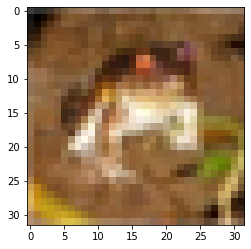

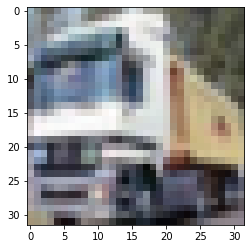

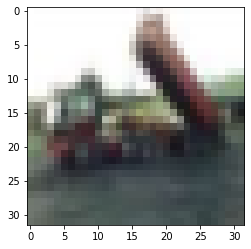

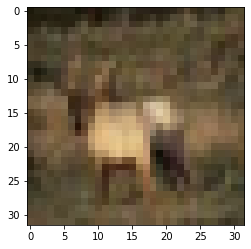

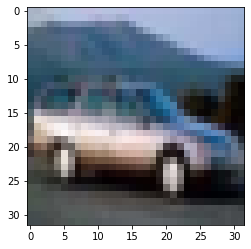

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for img in trainset.data[:5]:
  plt.figure()
  plt.imshow(img)

Mean and Standard deviation for dataset

In [ ]:
# cifar10_dataset = trainset.data

# data_r = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 0] for i in range(len(cifar10_dataset))])
# data_g = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 1] for i in range(len(cifar10_dataset))])
# data_b = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 2] for i in range(len(cifar10_dataset))])
# mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
# std = np.std(data_r), np.std(data_g), np.std(data_b)

# print(f'Training dataset shape: {trainset.data.shape}')
# print(f'Training dataset mean: {mean}')
# print(f'Training dataset std: {std}')

Training dataset shape: (50000, 32, 32, 3)
Training dataset mean: (0.4890062, 0.47970363, 0.47680542)
Training dataset std: (0.264582, 0.258996, 0.25643882)


In [ ]:
# cifar10_dataset = trainset.data

# data_r = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 0] for i in range(len(cifar10_dataset))])
# data_g = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 1] for i in range(len(cifar10_dataset))])
# data_b = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 2] for i in range(len(cifar10_dataset))])
# mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
# std = np.std(data_r), np.std(data_g), np.std(data_b)

# print(f'Training dataset shape: {trainset.data.shape}')
# print(f'Training dataset mean: {mean}')
# print(f'Training dataset std: {std}')

TypeError: ignored

Let us show some of the training images, for fun.



 ship  bird   cat   dog


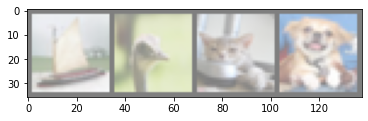

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Custom Resnet Model has 6.5M parameters.

In [8]:
from cifar_models import CustomResNet
net = CustomResNet().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [23]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    # scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

LR TEST FOR FINDING MAX LR

In [24]:
train_losses = dict()
test_losses = dict()
train_acc = dict()
test_acc = dict()

for lr in [1e-5, 1e-4, 1e-3, 1e-2]:
  print(f'Testing for lr={lr}')
  train_losses[lr] = list()
  test_losses[lr] = list()
  train_acc[lr] = list()
  test_acc[lr] = list()
  model =  CustomResNet().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 10
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, optimizer, epoch, train_losses[lr], train_acc[lr])
      test(model, device, testloader, test_losses[lr], test_acc[lr])

  0%|          | 0/98 [00:00<?, ?it/s]

Testing for lr=1e-05
EPOCH: 1


/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=2.092026948928833 Batch_id=97 Accuracy=17.38: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2490, Accuracy: 2386/10000 (23.86%)

EPOCH: 2


Loss=1.5489202737808228 Batch_id=97 Accuracy=37.50: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4845, Accuracy: 4658/10000 (46.58%)

EPOCH: 3


Loss=1.2084993124008179 Batch_id=97 Accuracy=51.41: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2049, Accuracy: 5623/10000 (56.23%)

EPOCH: 4


Loss=0.9225845336914062 Batch_id=97 Accuracy=61.39: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2812, Accuracy: 5719/10000 (57.19%)

EPOCH: 5


Loss=0.9136276245117188 Batch_id=97 Accuracy=68.15: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9519, Accuracy: 6844/10000 (68.44%)

EPOCH: 6


Loss=0.6851631999015808 Batch_id=97 Accuracy=72.90: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7841, Accuracy: 7316/10000 (73.16%)

EPOCH: 7


Loss=0.6814903020858765 Batch_id=97 Accuracy=76.73: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7460, Accuracy: 7432/10000 (74.32%)

EPOCH: 8


Loss=0.5804531574249268 Batch_id=97 Accuracy=79.05: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6234, Accuracy: 7935/10000 (79.35%)

EPOCH: 9


Loss=0.5139417052268982 Batch_id=97 Accuracy=81.46: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5699, Accuracy: 8078/10000 (80.78%)

EPOCH: 10


Loss=0.5212705731391907 Batch_id=97 Accuracy=83.40: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5270, Accuracy: 8221/10000 (82.21%)

Testing for lr=0.0001
EPOCH: 1


Loss=1.7998778820037842 Batch_id=97 Accuracy=20.59: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8215, Accuracy: 3420/10000 (34.20%)

EPOCH: 2


Loss=1.4913876056671143 Batch_id=97 Accuracy=41.36: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3774, Accuracy: 5135/10000 (51.35%)

EPOCH: 3


Loss=1.1111820936203003 Batch_id=97 Accuracy=54.46: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1329, Accuracy: 5908/10000 (59.08%)

EPOCH: 4


Loss=0.8817835450172424 Batch_id=97 Accuracy=62.86: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9452, Accuracy: 6640/10000 (66.40%)

EPOCH: 5


Loss=0.7766478657722473 Batch_id=97 Accuracy=69.69: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8687, Accuracy: 6957/10000 (69.57%)

EPOCH: 6


Loss=0.7183418273925781 Batch_id=97 Accuracy=73.53: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7137, Accuracy: 7482/10000 (74.82%)

EPOCH: 7


Loss=0.6655076146125793 Batch_id=97 Accuracy=77.65: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6276, Accuracy: 7831/10000 (78.31%)

EPOCH: 8


Loss=0.7102746963500977 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6505, Accuracy: 7813/10000 (78.13%)

EPOCH: 9


Loss=0.5199076533317566 Batch_id=97 Accuracy=82.03: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5230, Accuracy: 8199/10000 (81.99%)

EPOCH: 10


Loss=0.4603053629398346 Batch_id=97 Accuracy=83.29: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5705, Accuracy: 8162/10000 (81.62%)

Testing for lr=0.001
EPOCH: 1


Loss=1.6716631650924683 Batch_id=97 Accuracy=27.26: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5803, Accuracy: 4255/10000 (42.55%)

EPOCH: 2


Loss=1.3272289037704468 Batch_id=97 Accuracy=47.71: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3447, Accuracy: 5193/10000 (51.93%)

EPOCH: 3


Loss=0.9657858610153198 Batch_id=97 Accuracy=59.12: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1571, Accuracy: 5916/10000 (59.16%)

EPOCH: 4


Loss=0.8941327333450317 Batch_id=97 Accuracy=67.58: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9010, Accuracy: 6809/10000 (68.09%)

EPOCH: 5


Loss=0.7300395965576172 Batch_id=97 Accuracy=73.77: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7117, Accuracy: 7501/10000 (75.01%)

EPOCH: 6


Loss=0.5737756490707397 Batch_id=97 Accuracy=77.55: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5942, Accuracy: 7919/10000 (79.19%)

EPOCH: 7


Loss=0.5091854929924011 Batch_id=97 Accuracy=80.54: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5812, Accuracy: 7954/10000 (79.54%)

EPOCH: 8


Loss=0.4960651993751526 Batch_id=97 Accuracy=82.94: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5219, Accuracy: 8243/10000 (82.43%)

EPOCH: 9


Loss=0.5061909556388855 Batch_id=97 Accuracy=84.44: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5544, Accuracy: 8137/10000 (81.37%)

EPOCH: 10


Loss=0.35055673122406006 Batch_id=97 Accuracy=86.04: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5041, Accuracy: 8372/10000 (83.72%)

Testing for lr=0.01
EPOCH: 1


Loss=2.0223636627197266 Batch_id=97 Accuracy=21.85: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8550, Accuracy: 3168/10000 (31.68%)

EPOCH: 2


Loss=1.3555352687835693 Batch_id=97 Accuracy=40.03: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4361, Accuracy: 4703/10000 (47.03%)

EPOCH: 3


Loss=1.3011869192123413 Batch_id=97 Accuracy=52.61: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2587, Accuracy: 5574/10000 (55.74%)

EPOCH: 4


Loss=0.8360699415206909 Batch_id=97 Accuracy=62.58: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0485, Accuracy: 6251/10000 (62.51%)

EPOCH: 5


Loss=0.8239317536354065 Batch_id=97 Accuracy=69.25: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8194, Accuracy: 7150/10000 (71.50%)

EPOCH: 6


Loss=0.6753965616226196 Batch_id=97 Accuracy=75.09: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7030, Accuracy: 7569/10000 (75.69%)

EPOCH: 7


Loss=0.5459439158439636 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6324, Accuracy: 7843/10000 (78.43%)

EPOCH: 8


Loss=0.5494817495346069 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6443, Accuracy: 7748/10000 (77.48%)

EPOCH: 9


Loss=0.5170239210128784 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5824, Accuracy: 8069/10000 (80.69%)

EPOCH: 10


Loss=0.41480231285095215 Batch_id=97 Accuracy=83.71: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.5248, Accuracy: 8280/10000 (82.80%)



In [26]:
for lr in [1e-5, 1e-4, 1e-3, 1e-2]:
  print(lr, min(test_losses[lr]))

1e-05 0.5270288520812988
0.0001 0.5230412246704101
0.001 0.504125309753418
0.01 0.5248147918701171


For choosing max_lr, model was trained for 10 epochs from scratch with 4 LRs - 1e-5, 1e-4, 1e-3, 1e-2. The minimum test losses is in the order 1e-3 < 1e-4 < 1e-2 < 1e-5 (LR). We'll train using One Cycle LR using max_lr=1e-3, 1e-2 to have good range of LRs in a cycle. 

In [25]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, scheduler, epoch, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

Training using One Cycle LR Scheduler with following parameters: 
 1. min_lr=0 
 2. max_lr=1e-2 (calculated using LR test) 
 3. step_size_up=5*98, step_size_down=19*98) as 98 iterations in 1 epoch. Max_lr is achieved at 5th epoch, with total 24 epochs and no tempering.

 Max Validation accuracy of 88.68% in last epoch, although model starts to overfit (~5% difference between training and validation accuracies) from ~13th epoch. Therefore, validation accuracy can be improved by proper regularization.

In [11]:
from torch.optim.lr_scheduler import CyclicLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=0, max_lr=1e-2, step_size_up=5*98, step_size_down=19*98)
EPOCHS = 24

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, scheduler, epoch, train_losses, train_acc)
    test(model, device, testloader, test_losses, test_acc)
    print(f'LR: {scheduler.get_lr()}')

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=1.4883053302764893 Batch_id=97 Accuracy=30.70: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4321, Accuracy: 4794/10000 (47.94%)

LR: [0.0020000000000000035]
EPOCH: 2


Loss=1.1961607933044434 Batch_id=97 Accuracy=53.59: 100%|██████████| 98/98 [00:27<00:00,  3.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4627, Accuracy: 5011/10000 (50.11%)

LR: [0.003999999999999997]
EPOCH: 3


Loss=0.9241223335266113 Batch_id=97 Accuracy=63.12: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9345, Accuracy: 6744/10000 (67.44%)

LR: [0.006]
EPOCH: 4


Loss=0.8087830543518066 Batch_id=97 Accuracy=69.68: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9381, Accuracy: 6823/10000 (68.23%)

LR: [0.008000000000000004]
EPOCH: 5


Loss=0.681581974029541 Batch_id=97 Accuracy=73.74: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8234, Accuracy: 7186/10000 (71.86%)

LR: [0.009999999999999995]
EPOCH: 6


Loss=0.48862725496292114 Batch_id=97 Accuracy=77.57: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6592, Accuracy: 7768/10000 (77.68%)

LR: [0.009473684210526316]
EPOCH: 7


Loss=0.5129725337028503 Batch_id=97 Accuracy=80.50: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7249, Accuracy: 7608/10000 (76.08%)

LR: [0.008947368421052631]
EPOCH: 8


Loss=0.48640474677085876 Batch_id=97 Accuracy=83.06: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5199, Accuracy: 8211/10000 (82.11%)

LR: [0.008421052631578949]
EPOCH: 9


Loss=0.3974275588989258 Batch_id=97 Accuracy=84.90: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5405, Accuracy: 8205/10000 (82.05%)

LR: [0.007894736842105263]
EPOCH: 10


Loss=0.37237274646759033 Batch_id=97 Accuracy=86.36: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5203, Accuracy: 8296/10000 (82.96%)

LR: [0.007368421052631579]
EPOCH: 11


Loss=0.3899316191673279 Batch_id=97 Accuracy=87.65: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5181, Accuracy: 8284/10000 (82.84%)

LR: [0.006842105263157896]
EPOCH: 12


Loss=0.36541858315467834 Batch_id=97 Accuracy=88.75: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4652, Accuracy: 8486/10000 (84.86%)

LR: [0.006315789473684211]
EPOCH: 13


Loss=0.26866093277931213 Batch_id=97 Accuracy=89.98: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4680, Accuracy: 8497/10000 (84.97%)

LR: [0.005789473684210529]
EPOCH: 14


Loss=0.22378608584403992 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4318, Accuracy: 8622/10000 (86.22%)

LR: [0.005263157894736841]
EPOCH: 15


Loss=0.24571223556995392 Batch_id=97 Accuracy=92.15: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4180, Accuracy: 8637/10000 (86.37%)

LR: [0.004736842105263158]
EPOCH: 16


Loss=0.20472721755504608 Batch_id=97 Accuracy=92.86: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4339, Accuracy: 8643/10000 (86.43%)

LR: [0.004210526315789476]
EPOCH: 17


Loss=0.11873802542686462 Batch_id=97 Accuracy=93.39: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4047, Accuracy: 8709/10000 (87.09%)

LR: [0.0036842105263157877]
EPOCH: 18


Loss=0.16513387858867645 Batch_id=97 Accuracy=94.38: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3916, Accuracy: 8765/10000 (87.65%)

LR: [0.0031578947368421056]
EPOCH: 19


Loss=0.1526445746421814 Batch_id=97 Accuracy=94.97: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4079, Accuracy: 8732/10000 (87.32%)

LR: [0.002631578947368423]
EPOCH: 20


Loss=0.1512811928987503 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3889, Accuracy: 8768/10000 (87.68%)

LR: [0.002105263157894735]
EPOCH: 21


Loss=0.14826111495494843 Batch_id=97 Accuracy=95.95: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3839, Accuracy: 8793/10000 (87.93%)

LR: [0.0015789473684210528]
EPOCH: 22


Loss=0.10111469030380249 Batch_id=97 Accuracy=96.47: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3790, Accuracy: 8839/10000 (88.39%)

LR: [0.0010526315789473703]
EPOCH: 23


Loss=0.10829567909240723 Batch_id=97 Accuracy=96.82: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3682, Accuracy: 8849/10000 (88.49%)

LR: [0.0005263157894736824]
EPOCH: 24


Loss=0.11766988784074783 Batch_id=97 Accuracy=97.04: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.3663, Accuracy: 8868/10000 (88.68%)

LR: [0.0]


Training using One Cycle LR Scheduler with following parameters: 
 1. min_lr=0 
 2. max_lr=1e-3 (calculated using LR test) 
 3. step_size_up=5*98, step_size_down=19*98) as 98 iterations in 1 epoch. Max_lr is achieved at 5th epoch, with total 24 epochs and no tempering.

Max Validation accuracy of 75.83% in last epoch, which is way lesser that previous case of max_lr=1e-2. Therefore, max_lr=1e-2 is used going forward.

In [27]:
from torch.optim.lr_scheduler import CyclicLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=0, max_lr=1e-3, step_size_up=5*98, step_size_down=19*98)
EPOCHS = 24

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, scheduler, epoch, train_losses, train_acc)
    test(model, device, testloader, test_losses, test_acc)
    print(f'LR: {scheduler.get_lr()}')

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=2.01420259475708 Batch_id=97 Accuracy=17.90: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.9889, Accuracy: 2839/10000 (28.39%)

LR: [0.00020000000000000033]
EPOCH: 2


Loss=1.710505723953247 Batch_id=97 Accuracy=34.05: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6268, Accuracy: 4191/10000 (41.91%)

LR: [0.00039999999999999964]
EPOCH: 3


Loss=1.4237825870513916 Batch_id=97 Accuracy=43.74: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4242, Accuracy: 4840/10000 (48.40%)

LR: [0.0006]
EPOCH: 4


Loss=1.3198903799057007 Batch_id=97 Accuracy=49.68: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2876, Accuracy: 5352/10000 (53.52%)

LR: [0.0008000000000000003]
EPOCH: 5


Loss=1.2526671886444092 Batch_id=97 Accuracy=54.90: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1944, Accuracy: 5727/10000 (57.27%)

LR: [0.0009999999999999996]
EPOCH: 6


Loss=1.156143307685852 Batch_id=97 Accuracy=58.72: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1210, Accuracy: 6013/10000 (60.13%)

LR: [0.0009473684210526316]
EPOCH: 7


Loss=1.114357590675354 Batch_id=97 Accuracy=61.87: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0301, Accuracy: 6354/10000 (63.54%)

LR: [0.000894736842105263]
EPOCH: 8


Loss=1.0413225889205933 Batch_id=97 Accuracy=64.39: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9604, Accuracy: 6580/10000 (65.80%)

LR: [0.0008421052631578949]
EPOCH: 9


Loss=0.9402025938034058 Batch_id=97 Accuracy=66.25: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9410, Accuracy: 6681/10000 (66.81%)

LR: [0.0007894736842105263]
EPOCH: 10


Loss=0.9152888059616089 Batch_id=97 Accuracy=67.96: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9097, Accuracy: 6771/10000 (67.71%)

LR: [0.0007368421052631579]
EPOCH: 11


Loss=0.8580134510993958 Batch_id=97 Accuracy=69.50: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8583, Accuracy: 6944/10000 (69.44%)

LR: [0.0006842105263157897]
EPOCH: 12


Loss=0.7156370878219604 Batch_id=97 Accuracy=70.63: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8407, Accuracy: 7044/10000 (70.44%)

LR: [0.0006315789473684212]
EPOCH: 13


Loss=0.8391780853271484 Batch_id=97 Accuracy=71.71: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8139, Accuracy: 7122/10000 (71.22%)

LR: [0.0005789473684210529]
EPOCH: 14


Loss=0.7912859320640564 Batch_id=97 Accuracy=72.83: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8015, Accuracy: 7194/10000 (71.94%)

LR: [0.0005263157894736841]
EPOCH: 15


Loss=0.8612015247344971 Batch_id=97 Accuracy=73.59: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7792, Accuracy: 7229/10000 (72.29%)

LR: [0.0004736842105263158]
EPOCH: 16


Loss=0.7534193992614746 Batch_id=97 Accuracy=74.29: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7575, Accuracy: 7347/10000 (73.47%)

LR: [0.00042105263157894755]
EPOCH: 17


Loss=0.6624384522438049 Batch_id=97 Accuracy=75.08: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7474, Accuracy: 7343/10000 (73.43%)

LR: [0.00036842105263157874]
EPOCH: 18


Loss=0.674217700958252 Batch_id=97 Accuracy=75.57: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7292, Accuracy: 7440/10000 (74.40%)

LR: [0.0003157894736842106]
EPOCH: 19


Loss=0.6933937668800354 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7298, Accuracy: 7447/10000 (74.47%)

LR: [0.0002631578947368423]
EPOCH: 20


Loss=0.5898486971855164 Batch_id=97 Accuracy=76.68: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7115, Accuracy: 7530/10000 (75.30%)

LR: [0.0002105263157894735]
EPOCH: 21


Loss=0.6727530360221863 Batch_id=97 Accuracy=77.06: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7044, Accuracy: 7518/10000 (75.18%)

LR: [0.0001578947368421053]
EPOCH: 22


Loss=0.6010221838951111 Batch_id=97 Accuracy=77.30: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6996, Accuracy: 7539/10000 (75.39%)

LR: [0.00010526315789473704]
EPOCH: 23


Loss=0.6053389310836792 Batch_id=97 Accuracy=77.58: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6926, Accuracy: 7564/10000 (75.64%)

LR: [5.263157894736824e-05]
EPOCH: 24


Loss=0.7522563934326172 Batch_id=97 Accuracy=77.86: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.6909, Accuracy: 7583/10000 (75.83%)

LR: [0.0]


Given augmentation constraints, added L2 regularization and experimented with weight_decay values of 1e-5, 1e-3, 1e-1. The max validation accuracies for 1e-5, 1e-3 were similar to that without weight_decay, however, the model exhibited max validation accuracy of 91.78% in last epoch (second high of 90.44% in previous epoch).

In [11]:
from torch.optim.lr_scheduler import CyclicLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-1)
scheduler = CyclicLR(optimizer, base_lr=0, max_lr=1e-2, step_size_up=5*98, step_size_down=19*98)
EPOCHS = 24

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, scheduler, epoch, train_losses, train_acc)
    test(model, device, testloader, test_losses, test_acc)
    print(f'LR: {scheduler.get_lr()}')

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=1.4781142473220825 Batch_id=97 Accuracy=30.83: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5600, Accuracy: 4248/10000 (42.48%)

LR: [0.0020000000000000035]
EPOCH: 2


Loss=1.1773741245269775 Batch_id=97 Accuracy=53.94: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5765, Accuracy: 4532/10000 (45.32%)

LR: [0.003999999999999997]
EPOCH: 3


Loss=0.8700181245803833 Batch_id=97 Accuracy=64.60: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1464, Accuracy: 5949/10000 (59.49%)

LR: [0.006]
EPOCH: 4


Loss=0.7027729749679565 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2373, Accuracy: 5397/10000 (53.97%)

LR: [0.008000000000000004]
EPOCH: 5


Loss=0.6900178790092468 Batch_id=97 Accuracy=76.43: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8324, Accuracy: 7621/10000 (76.21%)

LR: [0.009999999999999995]
EPOCH: 6


Loss=0.6146531105041504 Batch_id=97 Accuracy=79.35: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9081, Accuracy: 7183/10000 (71.83%)

LR: [0.009473684210526316]
EPOCH: 7


Loss=0.7111073136329651 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9090, Accuracy: 7172/10000 (71.72%)

LR: [0.008947368421052631]
EPOCH: 8


Loss=0.6178562045097351 Batch_id=97 Accuracy=81.23: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9068, Accuracy: 7161/10000 (71.61%)

LR: [0.008421052631578949]
EPOCH: 9


Loss=0.6701841950416565 Batch_id=97 Accuracy=82.37: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7372, Accuracy: 7781/10000 (77.81%)

LR: [0.007894736842105263]
EPOCH: 10


Loss=0.6305354833602905 Batch_id=97 Accuracy=81.84: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7682, Accuracy: 7649/10000 (76.49%)

LR: [0.007368421052631579]
EPOCH: 11


Loss=0.5951655507087708 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7618, Accuracy: 7581/10000 (75.81%)

LR: [0.006842105263157896]
EPOCH: 12


Loss=0.6108182072639465 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9310, Accuracy: 7131/10000 (71.31%)

LR: [0.006315789473684211]
EPOCH: 13


Loss=0.552720308303833 Batch_id=97 Accuracy=84.53: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6307, Accuracy: 8160/10000 (81.60%)

LR: [0.005789473684210529]
EPOCH: 14


Loss=0.5545332431793213 Batch_id=97 Accuracy=85.03: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6190, Accuracy: 8209/10000 (82.09%)

LR: [0.005263157894736841]
EPOCH: 15


Loss=0.5355335474014282 Batch_id=97 Accuracy=85.66: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9344, Accuracy: 6926/10000 (69.26%)

LR: [0.004736842105263158]
EPOCH: 16


Loss=0.5134880542755127 Batch_id=97 Accuracy=86.10: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5843, Accuracy: 8317/10000 (83.17%)

LR: [0.004210526315789476]
EPOCH: 17


Loss=0.44849905371665955 Batch_id=97 Accuracy=87.08: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7519, Accuracy: 7561/10000 (75.61%)

LR: [0.0036842105263157877]
EPOCH: 18


Loss=0.4760575592517853 Batch_id=97 Accuracy=87.69: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5671, Accuracy: 8388/10000 (83.88%)

LR: [0.0031578947368421056]
EPOCH: 19


Loss=0.44263526797294617 Batch_id=97 Accuracy=88.06: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5130, Accuracy: 8580/10000 (85.80%)

LR: [0.002631578947368423]
EPOCH: 20


Loss=0.4300355017185211 Batch_id=97 Accuracy=89.13: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4948, Accuracy: 8579/10000 (85.79%)

LR: [0.002105263157894735]
EPOCH: 21


Loss=0.40643709897994995 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5233, Accuracy: 8464/10000 (84.64%)

LR: [0.0015789473684210528]
EPOCH: 22


Loss=0.3875690996646881 Batch_id=97 Accuracy=91.01: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4647, Accuracy: 8754/10000 (87.54%)

LR: [0.0010526315789473703]
EPOCH: 23


Loss=0.32811322808265686 Batch_id=97 Accuracy=92.44: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3718, Accuracy: 9044/10000 (90.44%)

LR: [0.0005263157894736824]
EPOCH: 24


Loss=0.3084712624549866 Batch_id=97 Accuracy=93.84: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.3344, Accuracy: 9178/10000 (91.78%)

LR: [0.0]


In [12]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  truck   cat   cat   car


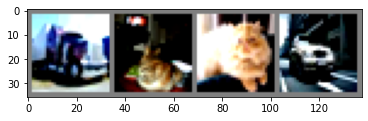

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [16]:
outputs = model(images[:4].to(device))
outputs, classes

/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


(tensor([[-5.1664, -4.3061, -5.5883, -5.4178, -5.5618, -5.5435, -5.5752, -5.0829,
          -5.1118, -0.0525],
         [-4.7372, -4.5897, -4.4506, -0.1461, -4.1463, -3.0584, -4.2372, -4.6393,
          -4.8334, -4.5577],
         [-5.1963, -5.3627, -4.9339, -0.0820, -4.9341, -3.7382, -4.3965, -4.8745,
          -5.3725, -5.1738],
         [-3.9773, -0.2687, -4.1540, -3.9426, -4.2397, -4.1636, -3.9813, -4.1734,
          -3.7988, -2.3496]], device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 ('plane',
  'car',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'))

The predictions for 4 sampled test images is same as the ground truth!

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck   cat   cat   car


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 91 %


The accuracy on 10000 test images is 91%!! Looking at classwise accuracy on test images below, the model performs good.

In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/cifar_models.py:165: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 87 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 81 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


Text(0.5, 1.0, 'Test Accuracy')

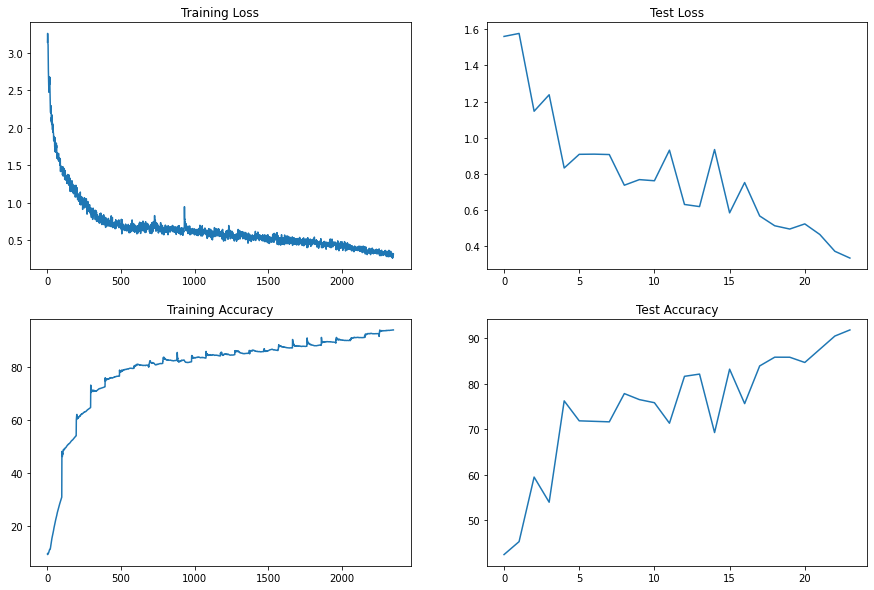

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")